In [1]:

from cooltools import insulation, snipping
from sklearn.mixture import GaussianMixture
from mirnylib.numutils import zoomArray
from functools import partial

import DNA_info
import matrix_manager as mm
import cooltools_pileups
%matplotlib inline

# Performing boundary pileup

In [ ]:
def rao_insulations():
    rao_path = './GSE63525_GM12878_primary+replicate_Arrowhead_domainlist_hg38.txt'
    rao_ins = pd.read_csv(rao_path, sep='\t')
    rao_starts = rao_ins[['chrom1','start1']].rename(columns={'chrom1':'chrom', 'start1':'pos'})
    rao_ends = rao_ins[['chrom1','end1']].rename(columns={'chrom1':'chrom', 'end1':'pos'})
    rao_ins = pd.concat([rao_starts, rao_ends]).sort_values(['chrom','pos'])

    ind = (rao_ins.iloc[1:]['pos'].values - rao_ins.iloc[0:-1]['pos'].values < 20000)
    ind = ind & (rao_ins.iloc[1:]['chrom'].values == rao_ins.iloc[0:-1]['chrom'].values)
    ind  = np.append(ind, True)
    rao_ins = rao_ins[~ind].reset_index(drop=True)
    
    return rao_ins

In [ ]:
db = mm.Database()
table = db.get_tables()
insulations = mm.filter_data(table, filter_dict={'seq':'deep'})
list_names = list(insulations['lib_name'].values) 
insulations = db.get_insulation(insulations, subdir='./insulation/10000/window_20px/')

table = mm.get_coolers(table, res=10000)

arms = DNA_info.get_chromosome_arms('hg38')
basepath = './pileups/boundaries/'

for lib_name in list_names:
    print(f'\n***** {lib_name} ****\n')
    
    if lib_name == 'rao2014':
        insul = rao_insulations()
    else:
        insul = insulations.loc[insulations.lib_name == lib_name, 'insulation_10000'].values[0]
        insul = insul.rename(columns={'log2_insulation_score_100000':'insul_score',
                                      'boundary_strength_100000':'strength'})
        insul['pos'] = (insul['start'] + insul['end'])//2
        insul = insul[['chrom','pos','insul_score','strength','category']].dropna()

    for cat in ['strong','weak']:
        ins = insul.copy()
        ins = ins[ins.category == cat]
        
        binned_list = snipping.make_bin_aligned_windows(10000, ins['chrom'].values, 
                                               ins['pos'].values, flank_bp=200000)
        features = snipping.assign_regions(binned_list, arms)
        assert np.all(features['region'].apply(lambda x: isinstance(x, str)))

        savepath = f'{basepath}{lib_name}/{cat}/10000/'
        os.makedirs(savepath, exist_ok=True)
    #         df = insul_tads[['chrom1','start1','start2','pos','strength1','strength2']]
    #         df = df.rename(columns={'chrom1':'chrom','start1':'start','start2':'end',
    #                                 'strength1':'start_strength', 'strength2':'end_strength'})
        assert len(ins) == len(features)
        ins.to_csv(f'{savepath}/boundaries.txt', sep='\t', header=True, index=False)

        for _, row in table.iterrows():
            name = row['lib_name']
            print(name)

            cool = row[f'cooler_{10000}']

            snipper = cooltools_pileups.LocalObsExpSnipper(cool, cooler_opts={'balance':True})
            with mp.Pool(20) as p:
                pileup = snipping.pileup(features, snipper.select, snipper.snip, map=p.map)

            np.save(f'{savepath}/{name}.npy', pileup)
            print(f'Saved to: {savepath}/{name}.npy')



# Visualization of the boundary enrichment score

In [4]:
imp.reload(mm)
db = mm.Database('./metadata/U54_matrix_info')
table = db.get_tables()
table = db.get_pileups(table, subdir='./pileups/boundaries/rao2014/10000/', col_name='boundaries')
pu = table.loc[28, 'boundaries'].load()

In [5]:
pu.shape

(41, 41, 14036)

/home/sameer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/home/sameer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
/home/sameer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10


1.3293929680177758

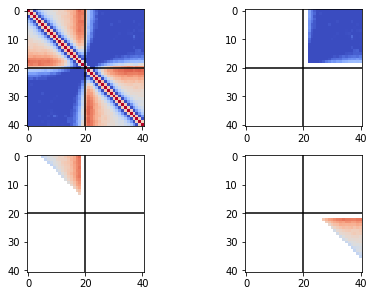

In [6]:
fig, ax  = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
p = np.nanmean(pu, axis=2)
l = p.shape[0]
ax[0,0].imshow(np.log10(p), cmap='coolwarm', vmin=-0.1, vmax=0.1)
ax[0,0].axhline(l//2, color='k')
ax[0,0].axvline(l//2, color='k')


mask = np.arange(p.shape[0])
mask = mask[None,:] - mask[:, None]

p1 = p.copy()
p1[:,0:(l//2 + l//20)] = 0
p1[(l//2 - l//20 + 1):, :] = 0
ax[0,1].imshow(np.log10(p1), cmap='coolwarm', vmin=-0.1, vmax=0.1)
ax[0,1].axhline(l//2, color='k')
ax[0,1].axvline(l//2, color='k')


p2 = p.copy()
p2[mask < 5] = 0
p2[:,(l//2 - l//20 + 1):] = 0
ax[1,0].imshow(np.log10(p2), cmap='coolwarm', vmin=-0.1, vmax=0.1)
ax[1,0].axhline(l//2, color='k')
ax[1,0].axvline(l//2, color='k')


p3 = p.copy()
p3[mask < 5] = 0
p3[0:(l//2 + l//20),:] = 0
ax[1,1].imshow(np.log10(p3), cmap='coolwarm', vmin=-0.1, vmax=0.1)
ax[1,1].axhline(l//2, color='k')
ax[1,1].axvline(l//2, color='k')

in1 = np.mean(p3[p3 != 0])
in2 = np.mean(p2[p2 != 0])

out = np.mean(p1[p1 != 0])

(in1 + in2)/(2*out)

# fig.savefig('/home/sameer/Dropbox (MIT)/Research/U54_matrix/insulation/boundaries/boundary_scores_image.png')

# Extracting Boundary Enrichment

In [2]:
def boundary_metric_rao(pileup):
    
    l = pileup.shape[0]
    mask = np.arange(l)
    mask = mask[None,:] - mask[:, None]
    
    out = pileup.copy()
    out[:,0:(l//2 + l//20)] = 0
    out[(l//2 - l//20 + 1):, :] = 0
    out = np.mean(out[out != 0])
    
    in1 = pileup.copy()
    in1[mask < 5] = 0
    in1[:,(l//2 - l//20 + 1):] = 0
    in1 = np.mean(in1[in1 != 0])
    
    in2 = pileup.copy()
    in2[mask < 5] = 0
    in2[0:(l//2 + l//20),:] = 0
    in2 = np.mean(in2[in2 != 0])
    
    return (in1 + in2)/(2*out)

def parallelize(tad_list, good_inds, name_snips):
    name, snips = name_snips
    print(name)
    
    snips = snips.load()
    if np.all(np.isnan(snips)):
        print(np.nan)
        return np.nan
    
    snips = snips[:,:, good_inds]
    arguments = [(snips[:,:,i], tad_list.loc[i, 'size']) for i in range(len(tad_list))]        
    new_snips = list(map(rescale_snips, arguments))
    new_snips = np.dstack(new_snips)

    pileup = np.nanmean(new_snips, axis=2)
    score = tad_metric_rao(pileup)
    
    print(score)
    return score


In [ ]:
db = mm.Dataset()
scores_df = db.get_tables()
scores_df = scores_df[['lib_name']]
scores_df.to_csv('./boundary_scores_strong.txt', sep='\t', header=True, index=False)

In [ ]:
base_path = '/net/levsha/share/sameer/U54/hic_matrix/pileups/boundaries/'
db = mm.Dataset()
list_names = db.get_tables()
list_names = mm.filter_data(list_names, filter_dict={'seq':'deep'})
list_names = ['rao2014'] + list(list_names['lib_name'].values) 

for cat in ['strong','weak']:
    
    for name in list_names[0:-1]:
        print(f'\n***** {name} ****\n')

        if name == 'rao2014':
            subfolder = name
        else:
            subfolder = f'insulations/boundaries/{name}/10000'
        table = db.get_tables()
        table = db.get_pileups(table, subdir=subfolder, col_name='boundaries')
        scores = []
        for i, row in table.iterrows():
            print(row['lib_name'])

            snips = row['boundaries_10000'].load()

            if np.all(np.isnan(snips)):
                scores.append(np.nan)
                print(np.nan)
                continue

            pileup = np.nanmean(snips, axis=2)
            score = boundary_metric_rao(pileup)
            print(score)
            scores.append(score)

            if np.random.random() < (3/70):
                plt.figure()
                plt.imshow(pileup, cmap='coolwarm')

        scores_df[f'{name}'] = scores
        scores_df.to_csv(f'./boundary_scores_{cat}.txt', sep='\t', header=True, index=False)

In [ ]:
cat = '_weak'
bound_df = pd.read_csv(f'./boundary_scores{cat}.txt', sep='\t')
db = mm.Dataset()
df = db.get_tables(['scaling_metrics'])
df = mm.filter_data(df, filter_dict={'cycle':['NS'], 'seq':['-','control']})
df = df.merge(bound_df, on='lib_name', how='outer').dropna()
df

In [ ]:
list_names = [col for col in bound_df.columns if col != 'lib_name']
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9,6), sharex=True, sharey=False, constrained_layout=True)
ax = ax.ravel()

cat1 = 'celltype'
if cat1 == 'celltype':
    colors = {'END':'g', 'ESC':'r', 'HFF':'b', 'HelaS3':'y'}
elif cat1 == 'xlink':
    colors = {'DSG':'r', 'EGS':'b', 'FA':'g'}
else:
    colors = {'MNase':'g', 'DpnII':'r', 'DdeI':'b', 'HindIII':'y'}
    
for i, name in enumerate(list_names):

    ax[i].set_title(name)
    for ct, group in df.groupby(cat1):
        if ct == 'double':
            continue
        x = group['avg_slope_100kb'].values
        y = group[name].values
        ax[i].scatter(x, y, label=ct, color=colors[ct])
ax[2].legend(bbox_to_anchor=[1, 0.5], loc='center left')

fig.savefig(f'/net/wiz/home/sameer/Dropbox (MIT)/Research/U54_matrix/insulation/boundaries/boundary_score_v_slope{cat}.pdf',
           format='pdf')

## Visualization of pileups

In [ ]:
list_names

In [ ]:
imp.reload(mm)
db = mm.Database()
table = db.get_tables()

In [ ]:
ind = np.random.choice(table.index.values)
name = 'U54-HFFc64DN-FA-DSG-MNase-R1-R2'#table.loc[ind, 'lib_name']
print(name)

In [ ]:
fig, ax  = plt.subplots(ncols=2, constrained_layout=True, figsize=(8,5))
list_name = 'U54-HFFc64DN-FA-DSG-MNase-R1-R2'
fig.suptitle(f'List from: {list_name}\n\n Pileup done on: {name}')
lim = 0.1
cat_list = ['strong', 'weak']
for i in range(2):
    df = mm.get_boundaries(table, f'{list_name}/{cat_list[i]}', 10000)
    pu = df.loc[ind, 'boundaries_10000'].load()
    p = np.nanmean(pu, axis=2)
    print(np.log10(p).min(), np.log10(p).max())
    ax[i].set_title(cat_list[i])
    ax[i].imshow(np.log10(p), cmap='coolwarm', vmin=-lim, vmax=lim)
    ax[i].axhline(20, color='k')
    ax[i].axvline(20, color='k')
    
fig.savefig(f'/home/sameer/Dropbox (MIT)/Research/U54_matrix/insulation/boundaries/sample_weak_strong_{name}.png')

## Control Case of Insulations + Random Shifts

In [ ]:
db = mm.Dataset()
table = db.get_tables()
insulations = mm.filter_data(table, filter_dict={'seq':'deep'})
table = mm.get_coolers(table, res=10000)
insulations = mm.get_insulation(insulations, res=10000)
display(insulations)
insulations = insulations.loc[7,'insulation_10000']
cool = table.loc[7, 'cooler_10000']
insulations = insulations.rename(columns={'log2_insulation_score_100000':'insul_score',
                                      'boundary_strength_100000':'strength'})
insulations['pos'] = (insulations['start'] + insulations['end'])//2
insulations = insulations[['chrom','pos','insul_score','strength','category']].dropna()

insulations

# Random Shift Control

In [ ]:
arms = DNA_info.get_chromosome_arms('hg38')
results = []
ins = insulations[insulations.category == 'strong']
for i in range(2):
    shifts = 0
    if i:
        shifts = np.round(np.random.uniform(low=200000, high=1000000, size=len(ins))).astype(int)
        directions = 2*np.random.binomial(1, 0.5, size=len(ins)) - 1
        shifts = shifts*directions
        
    binned_list = snipping.make_bin_aligned_windows(10000, ins['chrom'].values, 
                                               ins['pos'].values + shifts, flank_bp=200000)
    
    features = snipping.assign_regions(binned_list, arms).dropna()
    assert np.all(features['region'].apply(lambda x: isinstance(x, str)))

#     snipper = cooltools_pileups.LocalObsExpSnipper(cool, cooler_opts={'balance':True})
    snipper = snipping.CoolerSnipper(cool, cooler_opts={'balance':True})
    with mp.Pool(20) as p:
        pileup = snipping.pileup(features, snipper.select, snipper.snip, map=p.map)

    results.append(pileup)

In [ ]:
fig, ax  = plt.subplots(ncols=2, constrained_layout=True, figsize=(8,5))
list_name = 'U54-HFFc64DN-FA-DSG-MNase-R1-R2'
fig.suptitle(list_name)
ax[0].set_title('No shifts')
ax[1].set_title('With shifts')
lim = 0.2
for i in range(2):
    pileup = results[i]
    p = np.nanmean(pileup, axis=2)
    print(np.log10(p).min(), np.log10(p).max())
    ax[i].imshow(np.log10(p), cmap='fall', vmin=-2.75, vmax=-1.25)
    ax[i].axhline(20, color='k')
    ax[i].axvline(20, color='k')

# fig.savefig(f'/home/sameer/Dropbox (MIT)/Research/U54_matrix/insulation/boundaries/shifted_control.png')

# No OOE control

In [ ]:
insulations

In [ ]:
fig, ax  = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(7,7))
list_name = 'U54-HFFc64DN-FA-DSG-MNase-R1-R2'
fig.suptitle(list_name)
lim = 0.2

arms = DNA_info.get_chromosome_arms('hg38')

for i, cat in enumerate(['weak','strong']):
    ins = insulations[insulations.category == cat]
    results = []
    for j in range(2):

        binned_list = snipping.make_bin_aligned_windows(10000, ins['chrom'].values, 
                                                   ins['pos'].values, flank_bp=200000)

        features = snipping.assign_regions(binned_list, arms).dropna()
        assert np.all(features['region'].apply(lambda x: isinstance(x, str)))

        if not j:
            snipper = cooltools_pileups.LocalObsExpSnipper(cool, cooler_opts={'balance':True})
        else:
            snipper = snipping.CoolerSnipper(cool, cooler_opts={'balance':True})

        with mp.Pool(20) as p:
            pileup = snipping.pileup(features, snipper.select, snipper.snip, map=p.map)

        p = np.nanmean(pileup, axis=2)
        print(np.log10(p).min(), np.log10(p).max())
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        if not j:
            ax[i,j].imshow(np.log10(p), cmap='coolwarm', vmin=-lim, vmax=lim)
            ax[i,j].set_title('Obs Over Exp Pileup')
            ax[i,j].set_ylabel(f'{cat} boundaries')
        else:
            ax[i,j].imshow(np.log10(p), cmap='fall', vmin=-2.75, vmax=-1.75)
            ax[i,j].set_title('Raw Pileup')

fig.savefig(f'/home/sameer/Dropbox (MIT)/Research/U54_matrix/insulation/boundaries/ooe_control.png')       

# Pileups of Insulations peaks with and without dot anchors

In [ ]:
imp.reload(mm)
ds = mm.Dataset()
table = ds.get_tables()
table = mm.filter_data(table, filter_dict={'seq':'deep'}).reset_index(drop=True)
table = mm.get_coolers(table, res=10000)
table = mm.get_insulation(table, res=10000)
table = mm.get_compartments(table, res=10000)
table = mm.get_dot_calls(table, anchors=True, anchor_rad=10000).dropna()

table

In [ ]:
arms = DNA_info.get_chromosome_arms('hg38')

for i, row in table.iterrows():
    list_name = row['lib_name']
    cool = row['cooler_10000']
    insulations = row['insulation_10000']
    insulations = insulations.rename(columns={'log2_insulation_score_100000':'insulation',
                                      'boundary_strength_100000':'strength'})
    insulations = insulations[['chrom','start','end','insulation','strength','category']].dropna()

    anchors = row['anchors_10000']
    anchors = anchors.groupby('clust_id').aggregate({'chrom':'first','start':'min', 'end':'max', 'dot_id':'count'})
    anchors = anchors.rename(columns={'dot_id':'count'}).reset_index(drop=True)

    with tsv(insulations) as a, tsv(anchors) as b:
        out = bedtools.intersect(a=a.name, b=b.name, loj=True, wa=True, wb=True)
        out.columns = [x for x in insulations.columns] + ['dot_'+x for x in anchors.columns]

    out['pos'] = (out['start'] + out['end'])//2
    out['dot_count'] = out['dot_count'].apply(lambda x: 0 if x == '.' else int(x))
    out = out[['chrom', 'pos', 'insulation', 'strength', 'category', 'dot_count']]
    out['dot_occ'] = out['dot_count'].apply(lambda x: False if x==0 else True)

    results = []
    n_snips = []
    for cat in ['strong','weak']:
        
        for dot_occ in [True, False]:
            pu_list = out[(out.category == cat) & (out.dot_occ == dot_occ)]
            binned_list = snipping.make_bin_aligned_windows(10000, pu_list['chrom'].values, 
                                                       pu_list['pos'].values, flank_bp=200000)

            features = snipping.assign_regions(binned_list, arms).dropna()
            assert np.all(features['region'].apply(lambda x: isinstance(x, str)))

            snipper = cooltools_pileups.LocalObsExpSnipper(cool, cooler_opts={'balance':True})
            with mp.Pool(20) as p:
                pileup = snipping.pileup(features, snipper.select, snipper.snip, map=p.map)

            results.append(pileup)
            n_snips.append(len(features))
            
    fig, ax  = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(8,8))
    fig.suptitle(list_name, fontsize=16)
    # ax[0].set_title('No shifts')
    # ax[1].set_title('With shifts')
    lim=0.1
    for i in range(4):
        r = i//2
        c = i%2

        pileup = results[i]
        p = np.nanmean(pileup, axis=2)
        print(np.log10(p).min(), np.log10(p).max())

        if i == 0:
            ax[r,c].set_ylabel('Strong Boundary', fontsize=14)
            ax[r,c].set_title('With Dot Anchor', fontsize=14)
        if i == 1:
            ax[r,c].set_title('No Dot Anchor', fontsize=14)
        if i == 2:
            ax[r,c].set_ylabel('Weak Boundary', fontsize=14)

        ax[r,c].set_xlabel(n_snips[i])
        ax[r,c].set_xticks([])
        ax[r,c].set_yticks([])
        ax[r,c].imshow(np.log10(p), cmap='coolwarm', vmin=-lim, vmax=lim)
        ax[r,c].axhline(20, color='k')
        ax[r,c].axvline(20, color='k')

    fig.savefig(f'/home/sameer/Dropbox (MIT)/Research/U54_matrix/insulation/dot_anchors/{list_name}.png')
    
    
    

### Playing with thresholds on what constitutes a weak anchor with a dot

In [ ]:
arms = DNA_info.get_chromosome_arms('hg38')

list_name = table.loc[7, 'lib_name']
cool = table.loc[7, 'cooler_10000']

insulations = table.loc[7, 'insulation_10000']
insulations = insulations.rename(columns={'log2_insulation_score_100000':'insulation',
                                  'boundary_strength_100000':'strength'})
insulations = insulations[['chrom','start','end','insulation','strength','category']].dropna()

anchors = row['anchors_10000']
anchors = anchors.groupby('clust_id').aggregate({'chrom':'first','start':'min', 'end':'max', 'dot_id':'count'})
anchors = anchors.rename(columns={'dot_id':'count'}).reset_index(drop=True)

with tsv(insulations) as a, tsv(anchors) as b:
    out = bedtools.intersect(a=a.name, b=b.name, loj=True, wa=True, wb=True)
    out.columns = [x for x in insulations.columns] + ['dot_'+x for x in anchors.columns]

out['pos'] = (out['start'] + out['end'])//2
out['dot_count'] = out['dot_count'].apply(lambda x: 0 if x == '.' else int(x))
out = out[['chrom', 'pos', 'insulation', 'strength', 'category', 'dot_count']]


fig, ax  = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(9,9))
ax = ax.ravel()
fig.suptitle(f'Weak Boundaries for {list_name}', fontsize=14)

lim=0.1

for i, thres in enumerate([0, 2, 4, 6]):
    out['dot_occ'] = out['dot_count'].apply(lambda x: False if x<=thres else True)

    

    pu_list = out[(out.category == 'weak') & (out.dot_occ == False)]
    binned_list = snipping.make_bin_aligned_windows(10000, pu_list['chrom'].values, 
                                               pu_list['pos'].values, flank_bp=200000)

    features = snipping.assign_regions(binned_list, arms).dropna()
    assert np.all(features['region'].apply(lambda x: isinstance(x, str)))

    snipper = cooltools_pileups.LocalObsExpSnipper(cool, cooler_opts={'balance':True})
    with mp.Pool(20) as p:
        pileup = snipping.pileup(features, snipper.select, snipper.snip, map=p.map)


    p = np.nanmean(pileup, axis=2)
    print(np.log10(p).min(), np.log10(p).max())

    ax[i].set_title(f'more than {thres} dot anchors: {len(features)}', fontsize=10)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].imshow(np.log10(p), cmap='coolwarm', vmin=-lim, vmax=lim)
    ax[i].axhline(20, color='k')
    ax[i].axvline(20, color='k')
    
# fig.savefig(f'/home/sameer/Dropbox (MIT)/Research/U54_matrix/insulation/dot_anchors/{list_name}_weak_dot_occ.png')

In [ ]:
fig, ax = plt.subplots()
for cat in ['weak','strong']:
    _ = ax.hist(out.loc[out.category == cat, 'dot_count'].values, 
                bins=np.arange(1,16), histtype='step', label=cat)
ax.set_title(list_name)
ax.set_xlabel('Number of dot anchors associated with a boundary')
ax.set_xticks(np.arange(0.5, 15.5))
ax.set_xticklabels(np.arange(0, 16))
ax.legend()

fig.savefig(f'/home/sameer/Dropbox (MIT)/Research/U54_matrix/insulation/dot_anchors/{list_name}_dot_occ_hist.png')

# Dots anchors, Boundaries and Compartments

In [ ]:
arms = DNA_info.get_chromosome_arms('hg38')
lim=0.1
for i, row in table.iterrows():
    list_name = row['lib_name']
    cool = row['cooler_10000']
    insulations = row['insulation_10000']
    insulations = insulations.rename(columns={'log2_insulation_score_100000':'insulation',
                                      'boundary_strength_100000':'strength'})
    insulations = insulations[['chrom','start','end','insulation','strength','category']].dropna()

    anchors = row['anchors_10000']
    anchors = anchors.groupby('clust_id').aggregate({'chrom':'first','start':'min', 'end':'max', 'dot_id':'count'})
    anchors = anchors.rename(columns={'dot_id':'count'}).reset_index(drop=True)

    with tsv(insulations) as a, tsv(anchors) as b:
        out = bedtools.intersect(a=a.name, b=b.name, loj=True, wa=True, wb=True)
        out.columns = [x for x in insulations.columns] + ['dot_'+x for x in anchors.columns]

    out['dot_count'] = out['dot_count'].apply(lambda x: 0 if x == '.' else int(x))
    out = out[['chrom', 'start', 'end', 'insulation', 'strength', 'category', 'dot_count']]
    out['dot_occ'] = out['dot_count'].apply(lambda x: False if x==0 else True)

    vector = table.loc[4, 'vectors_10000']   
    merged = out.merge(vector[['chrom','start','end','E1']], on=['chrom','start','end'], how='inner') 
    merged['comp'] = merged['E1'].apply(lambda x: 'A' if x>=0 else 'B')
    merged['pos'] = (merged['start'] + merged['end'])//2
    

    for compartment in ['A', 'B']:
        fig, ax  = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(8,8))
        fig.suptitle(f'{list_name} {compartment} Compartment', fontsize=16)

        for i, cat in enumerate(['strong','weak']):

            for j, dot_occ in enumerate([True, False]):
                df = merged[merged.comp == compartment]
                pu_list = df[(df.category == cat) & (df.dot_occ == dot_occ)]
                binned_list = snipping.make_bin_aligned_windows(10000, pu_list['chrom'].values, 
                                                           pu_list['pos'].values, flank_bp=200000)

                features = snipping.assign_regions(binned_list, arms).dropna()
                assert np.all(features['region'].apply(lambda x: isinstance(x, str)))

                snipper = cooltools_pileups.LocalObsExpSnipper(cool, cooler_opts={'balance':True})
                with mp.Pool(20) as p:
                    pileup = snipping.pileup(features, snipper.select, snipper.snip, map=p.map)



                p = np.nanmean(pileup, axis=2)
                print(np.log10(p).min(), np.log10(p).max())

                if j == 0:
                    ax[i,j].set_ylabel(f'{cat} boundary', fontsize=14)
                if i == 0:
                    ax[i,j].set_title(f"{'With'*dot_occ + 'No'*(not dot_occ)} Dot Anchor", fontsize=14)
    #             if i == 1:
    #                 ax[r,c].set_title('No Dot Anchor', fontsize=14)
    #             if i == 2:
    #                 ax[r,c].set_ylabel('Weak Boundary', fontsize=14)

                ax[i,j].set_xlabel(f'# of sites: {len(features)}')
                ax[i,j].set_xticks([])
                ax[i,j].set_yticks([])
                ax[i,j].imshow(np.log10(p), cmap='coolwarm', vmin=-lim, vmax=lim)
                ax[i,j].axhline(20, color='k')
                ax[i,j].axvline(20, color='k')


        fig.savefig(f'/home/sameer/Dropbox (MIT)/Research/U54_matrix/insulation/dot_anchors/{compartment}_comp_pileup_{list_name}.png')




In [ ]:
merged

# Controlling for Insulations Score Parameters

In [ ]:
db = mm.Dataset()
table = db.get_tables()
table = mm.filter_data(table, filter_dict={'seq':'deep'}).reset_index(drop=True)
table
# 
# display(insulations)
# insulations = insulations.loc[7,'insulation_10000']
# cool = table.loc[7, 'cooler_10000']
# 

# insulations

In [ ]:
imp.reload(cooltools_pileups)
arms = DNA_info.get_chromosome_arms('hg38')
lim = 0.2

for ind in table.index.values:
    name = table.loc[ind, 'lib_name']
    
    for cat in ['strong', 'weak']:
        fig  = plt.figure(figsize=(10,10))
        fig.suptitle(f'{name} {cat}')
        gs = GridSpec(nrows=3, ncols=4, width_ratios=[90,90,90,5])

        for i, res in enumerate([1000, 10000, 25000]):
            print(res, '\n')
            coolers = mm.get_coolers(table, res=res)
            cool = coolers.loc[ind, f'cooler_{res}']

            for j, window in enumerate([5, 10, 20]):
                print(window, '\n')

                insulations = mm.get_insulation(table, res=res, window_px=window)
                ins = insulations.loc[ind, f'insulation_{res}_win{window}']
                ins = ins[ins.category == cat]
                ins = ins.rename(columns={'log2_insulation_score_100000':'insul_score',
                                          'boundary_strength_100000':'strength'})
                ins['pos'] = (ins['start'] + ins['end'])//2

                binned_list = snipping.make_bin_aligned_windows(res, ins['chrom'].values, 
                                                       ins['pos'].values, flank_bp=2*window*res)

                features = snipping.assign_regions(binned_list, arms).dropna()
                assert np.all(features['region'].apply(lambda x: isinstance(x, str)))

                snipper = cooltools_pileups.LocalObsExpSnipper(cool, cooler_opts={'balance':True})

                with mp.Pool(20) as p:
                    pileup = snipping.pileup(features, snipper.select, snipper.snip, map=p.map)

                ax = fig.add_subplot(gs[i,j])
                p = np.nanmean(pileup, axis=2)
                print(np.log10(p).min(), np.log10(p).max())
                ax.set_title(f'Res: {res}, Window: {window}')
                ax.set_xticks([])
                ax.set_yticks([])
                img = ax.imshow(np.log10(p), cmap='coolwarm', vmin=-lim, vmax=lim)

        cax = fig.add_subplot(gs[:,3])
        cbar = plt.colorbar(img, cax=cax, ticks=[-lim, -lim/2, 0, lim/2, lim])
        cax.set_yticklabels([f'<= -{lim}', f'-{lim/2}', '0', f'{lim/2}', f'>= {lim}'])
        fig.tight_layout(pad=3)
        fig.savefig(f'/home/sameer/Dropbox (MIT)/Research/U54_matrix/insulation/boundaries/res_window/{name}_{cat}.png')

In [ ]:
arms

In [ ]:
fig  = plt.figure(figsize=(10,10))#.subplots(nrows=3, ncols=3, constrained_layout=True, figsize=(9,6))
gs = GridSpec(nrows=3, ncols=4, width_ratios=[90,90,90,5])

# ax = ax.ravel()
# list_name = 'U54-HFFc64DN-FA-DSG-MNase-R1-R2'
# fig.suptitle(list_name)
# ax[0].set_title('No shifts')
# ax[1].set_title('With shifts')
lim = 0.2
for i in range(len(results)):
#     if i // 3 == 0:
#         r = 1
#     elif i // 3 == 1:
#         r = 10
#     else:
#         r = 25
        
#     if i % 3 == 0:
#         win = 5
#     elif i % 3 == 1:
#         win = 10
#     else:
#         win = 20

    r = i//3
    c = i%3
    
    ax = fig.add_subplot(gs[r,c])
    fig.suptitle('Title')
    pileup = results[i]
    p = np.nanmean(pileup, axis=2)
    print(np.log10(p).min(), np.log10(p).max())
    ax.set_title(f'Res: {r}, Window: {win}')
    ax.set_xticks([])
    ax.set_yticks([])
    img = ax.imshow(np.log10(p), cmap='coolwarm', vmin=-lim, vmax=lim)
    
cax = fig.add_subplot(gs[:,3])
cbar = plt.colorbar(img, cax=cax, ticks=[-lim, -lim/2, 0, lim/2, lim])
cax.set_yticklabels([f'<= -{lim}', f'-{lim/2}', '0', f'{lim/2}', f'>= {lim}'])
#     ax[i].axhline(20, color='k')
#     ax[i].axvline(20, color='k')
fig.tight_layout(pad=3)
# fig.savefig(f'/home/sameer/Dropbox (MIT)/Research/U54_matrix/insulation/boundaries/shifted_control.png')

# Boundary Scores for different Insulation Parameters

In [ ]:
df = db.get_tables('scaling_metrics')
df = df[['lib_name','celltype','xlink','enzyme','avg_slope_100kb']]
df['score'] = np.nan
df

In [ ]:
coolers

In [ ]:
db = mm.Dataset()
table = db.get_tables()
table = mm.filter_data(table, filter_dict={'cycle':'NS'})
arms = DNA_info.get_chromosome_arms('hg38')

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10), 
                       sharex=True, sharey=False, constrained_layout=True)
fig.suptitle('Boundary Score v/s Scaling Slope', fontsize=18, fontweight='bold')
color_dict = {'END':'g','ESC':'r','HFF':'b', 'HelaS3':'m'}
for i, res in enumerate([10000, 25000]):
    print(f'\n\n>>>>>>>>>>>>>>>>>{res}<<<<<<<<<<<<<<<<<<\n\n')
    
    coolers = mm.get_coolers(table, res=res)

    for j, window in enumerate([10, 20]):
        print(f'\n\n>>>>>>>>>>>>>>>>>{window}<<<<<<<<<<<<<<<<<<\n\n')
        
        ins_path = f'./insulation/{res}/window_{window}px/U54-HFFc6-DSG-DpnII-R1-R2.txt'
        insulations = pd.read_csv(ins_path, sep='\t')
        insulations = insulations.rename(columns={f'log2_insulation_score_{res*window}':'insul_score',
                                      f'boundary_strength_{res*window}':'strength'})
        insulations['pos'] = (insulations['start'] + insulations['end'])//2
        insulations = insulations[['chrom','pos','insul_score','strength','category']].dropna()

         
        ins = insulations.copy()
        ins = ins[ins.category == 'strong']
        
        binned_list = snipping.make_bin_aligned_windows(res, ins['chrom'].values, 
                                               ins['pos'].values, flank_bp=2*window*res)
        features = snipping.assign_regions(binned_list, arms)
        assert np.all(features['region'].apply(lambda x: isinstance(x, str)))
        
        result_df = db.get_tables('scaling_metrics')
        result_df = mm.filter_data(result_df, filter_dict={'cycle':'NS'})
        result_df = result_df[['lib_name','celltype','xlink','enzyme','avg_slope_100kb']]
        result_df['score'] = np.nan
        
        for k, row in coolers.iterrows():
            name = row['lib_name']
            print(name)

            cool = row[f'cooler_{res}']

            snipper = cooltools_pileups.LocalObsExpSnipper(cool, cooler_opts={'balance':True})
            with mp.Pool(20) as p:
                snips = snipping.pileup(features, snipper.select, snipper.snip, map=p.map)


            if np.all(np.isnan(snips)):
                print(np.nan)
                continue

            pileup = np.nanmean(snips, axis=2)
            score = boundary_metric_rao(pileup)
            print(score)
            result_df.loc[k, 'score'] = score

        
        if not i:
            ax[i,j].set_title(f'Window: {window} pixels', fontsize=14, fontweight='bold')
        else:
            ax[i,j].set_xlabel('Avg. Slope (1-100kb)', fontsize=14)
        if not j:
            ax[i,j].set_ylabel(f'Resolution: {res}', fontsize=14, fontweight='bold')
            
        
        for ct, group in result_df.groupby('celltype'):
            x = group['avg_slope_100kb'].values
            y = group['score'].values
            
            ax[i,j].scatter(x, y, s=20, c=color_dict[ct], label=ct)
            
        ax[i,j].legend()
             
fig.savefig('/home/sameer/Dropbox (MIT)/Research/U54_matrix/insulation/boundaries/res_window/scatter.png')


# Pileup for Betul

In [3]:
arms = DNA_info.get_chromosome_arms('hg38')

savepath = f'/home/sameer/Dropbox (MIT)/Research/U54_matrix/betul/boundary/union/'
os.makedirs(savepath, exist_ok=True)
ins_path = '/home/sameer/Dropbox (MIT)/Research/U54_matrix/betul/'
ins_dict = {'ESC':'ESC4DN-FA-DpnII-ESC4DN-DSG-DpnII-H1ESC4DN-FA-DSG-MNase_union.txt',
            'HFF':'HFFc6-FA-DpnII-HFFc6-DSG-DpnII-HFFc6-FA-DSG-MNase_union.txt'}

INFO:numexpr.utils:Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.



 U54-HFF-plate-DSG-MNase-20190509-R2-T1__hg38 

('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr18', 0, 18161052) ('chr18', 0, 18161052)
('chr18', 18161052, 80373285) ('chr18', 18161052, 80373285)
('chr19', 0, 25

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr20', 0, 28237290) ('chr20', 0, 28237290)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)
('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060,

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


-0.4111024889499679 0.32083725664635265

 U54-HFF-plate-EGS-MNase-20190509-R2-T1__hg38 

('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr18', 0, 18161052) ('chr18', 0, 18161052)
('chr18', 18161052, 80373285) ('chr

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:84: RuntimeWarning: divide by zero encountered in log10
  f = interp1d(np.log10(bin_mids), np.log10(coarse_expected), kind='linear')
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:89: RuntimeWarning: invalid value encountered in double_scalars
  yremaining = y[-1] + ((y[-1]-y[-2])/(x[-1]-x[-2]))*(xremaining - x[-1])
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:105: RuntimeWarning: divide by zero encountered in true_divide
  matrix.data = data/fine_expected[diff]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:105: RuntimeWarning: invalid value encountered in true_divide
  matrix.data = data/fine_expected[diff]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_ex

('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)
('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 4445409

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


-0.4188538531986912 0.32458997194570727

 U54-HFF-plate-FA-MNase-20190509-R2-T1__hg38 



/home/sameer/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr18', 0, 18161052) ('chr18', 0, 18161052)
('chr18', 18161052, 80373285) ('chr18', 18161052, 80373285)
('chr19', 0, 25844927) ('chr19', 0, 25844927)
('chr19', 25844927

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)
('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 4445409

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:84: RuntimeWarning: divide by zero encountered in log10
  f = interp1d(np.log10(bin_mids), np.log10(coarse_expected), kind='linear')
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:105: RuntimeWarning: divide by zero encountered in true_divide
  matrix.data = data/fine_expected[diff]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scalin

-0.36104764425768476 0.30059687917882005

 U54-HFF-plate-DSG-DdeI-20160812-R1-T1__hg38 



/home/sameer/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr18', 0, 18161052) ('chr18', 0, 18161052)
('chr18', 18161052, 80373285) ('chr18', 18161052, 80373285)
('chr19', 0, 25844927) ('chr19', 0, 25844927)
('chr19', 25844927

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)
('chr3', 0, 92214016) ('chr3', 0, 92214016)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)
('chrY', 0, 10430491) ('chrY', 0, 10430491)
('chrY', 10430491, 57227415) ('chrY', 10430491, 57227415)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:84: RuntimeWarning: divide by zero encountered in log10
  f = interp1d(np.log10(bin_mids), np.log10(coarse_expected), kind='linear')
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:105: RuntimeWarning: divide by zero encountered in true_divide
  matrix.data = data/fine_expected[diff]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:105: RuntimeWarning: invalid value encountered in true_divide
  matrix.data = data/fine_exp

-0.22318185329551668 0.31446911878931155

 U54-HFF-plate-EGS-DdeI-20161031-R1-T1__hg38 



/home/sameer/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr18', 0, 18161052) ('chr18', 0, 18161052)
('chr18', 18161052, 80373285) ('chr18', 18161052, 80373285)
('chr19', 0, 25844927) ('chr19', 0, 25844927)
('chr19', 25844927

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)
('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)
('chrY', 0, 10430491) ('chrY', 0, 10430491)
('ch

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:84: RuntimeWarning: divide by zero encountered in log10
  f = interp1d(np.log10(bin_mids), np.log10(coarse_expected), kind='linear')
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:105: RuntimeWarning: divide by zero encountered in true_divide
  matrix.data = data/fine_expected[diff]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:105: RuntimeWarning: invalid value encountered in true_divide
  matrix.data = data/fine_expected[diff]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/lo

-0.18145255012048017 0.3077424652567266


/home/sameer/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



 U54-HFF-plate-FA-DdeI-20170119-R2-T1__hg38 

('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr18', 0, 18161052) ('chr18', 0, 18161052)
('chr18', 18161052, 80373285) ('chr18', 18161052, 80373285)
('chr19', 0, 2584

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)
('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chrY', 10430491, 57227415) ('chrY', 10430491, 57227415)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


-0.1851598506657965 0.3022317897394452


/home/sameer/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



 U54-HFF-plate-DSG-DpnII-20170119-R2-T1__hg38 

('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr18', 0, 18161052) ('chr18', 0, 18161052)
('chr18', 18161052, 80373285) ('chr18', 18161052, 80373285)
('chr19', 0, 25

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)
('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


-0.21693072071766994 0.30504256623621817


/home/sameer/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



 U54-HFF-plate-EGS-DpnII-20160902-R1-T1__hg38 

('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr18', 0, 18161052) ('chr18', 0, 18161052)
('chr18', 18161052, 80373285) ('chr18', 18161052, 80373285)
('chr19', 0, 25

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)
('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060,

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


-0.21825601555340624 0.3082148458027656


/home/sameer/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



 U54-HFF-plate-FA-DpnII-20180904-R1-T1__hg38 

('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr18', 0, 18161052) ('chr18', 0, 18161052)
('chr18', 18161052, 80373285) ('chr18', 18161052, 80373285)
('chr19', 0, 258

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)
('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 4445409

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:84: RuntimeWarning: divide by zero encountered in log10
  f = interp1d(np.log10(bin_mids), np.log10(coarse_expected), kind='linear')
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:105: RuntimeWarning: divide by zero encountered in true_divide
  matrix.data = data/fine_expected[diff]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:105: RuntimeWarning: invalid value encountered in true_divide
  matrix.data = data/fine_expected[diff]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/lo

-0.17971441604967528 0.2999265925319545


/home/sameer/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



 U54-HFF-plate-DSG-HindIII-20160226-R1-T1__hg38 

('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr18', 0, 18161052) ('chr18', 0, 18161052)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr18', 18161052, 80373285) ('chr18', 18161052, 80373285)
('chr19', 0, 

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)
('chrY', 0, 10430491) ('chrY', 0, 10430491)
('chrY', 10430491, 57227415) ('chrY', 10430491, 57227415)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:84: RuntimeWarning: divide by zero encountered in log10
  f = interp1d(np.log10(bin_mids), np.log10(coarse_expected), kind='linear')
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:105: RuntimeWarning: divide by zero encountered in true_divide
  matrix.data = data/fine_expected[diff]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:105: RuntimeWarning: invalid value encountered in true_divide
  matrix.data = data/fine_expected[diff]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/lo

-0.20368442317495156 0.3107331850614655


/home/sameer/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



 U54-HFF-plate-EGS-HindIII-20190718-R2-T1__hg38 

('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr18', 0, 18161052) ('chr18', 0, 18161052)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr18', 18161052, 80373285) ('chr18', 18161052, 80373285)
('chr19', 0, 

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)
('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 4445409

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


-0.17871215611964947 0.3118265054849485


/home/sameer/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



 U54-HFF-plate-FA-HindIIII-20160226-R2-T1__hg38 

('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr18', 0, 18161052) ('chr18', 0, 18161052)
('chr18', 18161052, 80373285) ('chr18', 18161052, 80373285)
('chr19', 0, 

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)
('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)
('chrY', 0, 10430491) ('chrY', 0, 10430491)
('ch

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


-0.17229299982822238 0.308661160524838


/home/sameer/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


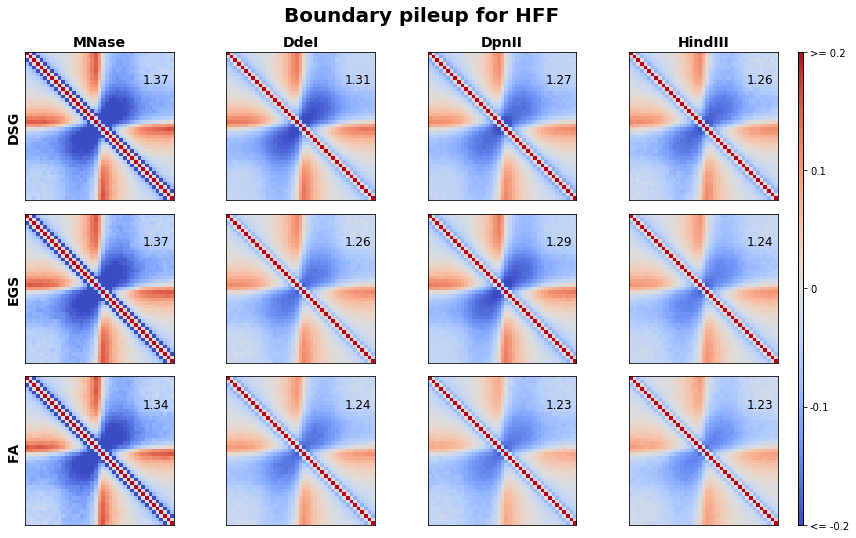

In [14]:
celltype = 'HFF'
lim=0.2
res = 10000
win = 10 

ins_list = pd.read_csv(f'{ins_path}{ins_dict[celltype]}', sep=',', header=None)
ins_list = ins_list[0].apply(lambda x: pd.Series(x.split('\t')[0:3]))
ins_list = ins_list.rename(columns={0:'chrom',1:'start',2:'end'})
ins_list['start'] = ins_list['start'].astype(int)
ins_list['end'] = ins_list['end'].astype(int)
ins_list = ins_list.sort_values(['chrom','start','end']).reset_index(drop=True)
ins_list['pos'] = (ins_list['start'] + ins_list['end'])//2
# display(ins_list.head())

binned_list = snipping.make_bin_aligned_windows(res, ins_list['chrom'].values, 
                                                   ins_list['pos'].values, flank_bp=2*win*res)
features = snipping.assign_regions(binned_list, arms)
assert np.all(features['region'].apply(lambda x: isinstance(x, str)))

# display(features.head())
filt_dict = {'celltype':celltype, 'seq':['-','control'], 
             'xlink':['DSG','EGS','FA'], 'enzyme':['MNase','DdeI','DpnII','HindIII']}

db = mm.Dataset()
table = db.get_tables()
table = mm.filter_data(table, filter_dict=filt_dict)
table = mm.get_coolers(table, res=res)

table['order'] = table['xlink'].replace({'DSG':0,'EGS':1,'FA':2})
table = table.set_index('order').sort_index().reset_index(drop=True)

table['order'] = table['enzyme'].replace({'MNase':0,'double':1,'DdeI':2,'DpnII':3, 'HindIII':4,})
table = table.set_index('order').sort_index().reset_index(drop=True)

fig = plt.figure(figsize=(13, 8))
fig.suptitle(f'Boundary pileup for {celltype}', fontsize=20, fontweight='bold')
gs = GridSpec(nrows=3, ncols=5, width_ratios=[90,90,90,90,2])

for i, row in table.iterrows():
    
    r = i%3
    c = i//3
    
    print('\n', row['lib_name'], '\n')
    xl = row['xlink']
    enz = row['enzyme']

    cool = row[f'cooler_{res}']
    snipper = cooltools_pileups.LocalObsExpSnipper(cool, cooler_opts={'balance':True})
    with mp.Pool(20) as p:
        snips = snipping.pileup(features, snipper.select, snipper.snip, map=p.map)

    if np.all(np.isnan(snips)):
        print(np.nan)
        continue

    pileup = np.nanmean(snips, axis=2)
    score = np.round(boundary_metric_rao(pileup), 2)
#     np.savetxt(f'{savepath}{ct}_{xl}_{enz}_pileup.txt', pileup, delimiter=',') 
    print(np.log10(pileup).min(), np.log10(pileup).max())
    ax = fig.add_subplot(gs[r,c])
    if r == 0:
        ax.set_title(enz, fontsize=14, fontweight='bold')
    if c == 0:
        ax.set_ylabel(xl, fontsize=14, fontweight='bold')
    ax.set_xticks([])
    ax.set_yticks([])
    img = ax.imshow(np.log10(pileup), cmap='coolwarm', vmin=-lim, vmax=lim)
    ax.text(int(pileup.shape[0]*0.8),int(pileup.shape[0])*0.2, score, fontsize=12)

    cax = fig.add_subplot(gs[:,-1])
    cbar = plt.colorbar(img, cax=cax, ticks=[-lim, -lim/2, 0, lim/2, lim])
    cax.set_yticklabels([f'<= -{lim}', f'-{lim/2}', '0', f'{lim/2}', f'>= {lim}'])
    fig.tight_layout(pad=4, w_pad=1, h_pad=1)

# #     x = np.log10(insul['strength'].values)
# #     _ = ax.hist(x, bins=bins)
    fig.savefig(f'{savepath}/{celltype}.pdf', format='pdf')
    fig.savefig(f'{savepath}/{celltype}.png', format='png')



In [ ]:
imp.reload(mm)
ds = mm.Dataset()
table = ds.get_tables()
table = mm.filter_data(table, filter_dict={'seq':'deep'})
ins_res = 1000
win = 20
table = mm.get_insulation(table, res=ins_res, window_px=win)
table = mm.get_dot_calls(table, anchors=True, anchor_rad=10000)
table = mm.get_coolers(table, res=1000).dropna()
table

In [ ]:
dot_thres = 0
distance = 500000
dist_range = 200000

arms = DNA_info.get_chromosome_arms('hg38')
for _, row in table.iterrows():
    name = row['lib_name']
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), constrained_layout=True,
                       sharex=True, sharey=True)
    fig.suptitle(name)

    ins = row[f'insulation_{ins_res}_win{win}'].dropna().reset_index(drop=True)
    ins = ins.rename(columns={f'log2_insulation_score_{ins_res*win}':'insulation',
                              f'boundary_strength_{ins_res*win}':'strength'})
    ins = ins[['chrom','start','end', 'insulation', 'strength', 'category']]
    anchors = row['anchors_10000']
    anchors = anchors.groupby('clust_id').aggregate({'chrom':'first','start':'min', 'end':'max', 'dot_id':'count'})
    anchors = anchors.rename(columns={'dot_id':'count'}).reset_index(drop=True)

    with tsv(ins) as a, tsv(anchors) as b:
        out = bedtools.intersect(a=a.name, b=b.name, loj=True, wa=True, wb=True)
        out.columns = [x for x in ins.columns] + ['dot_'+x for x in anchors.columns]

    out['dot_count'] = out['dot_count'].apply(lambda x: 0 if x == '.' else int(x))
    out = out[['chrom', 'start', 'end', 'insulation', 'strength', 'category', 'dot_count']]
    out['dot_occ'] = out['dot_count'].apply(lambda x: False if x<=dot_thres else True)



    for j, cat in enumerate(['strong', 'weak']):

        df = out.loc[out.dot_occ & (out['category'] == cat)].copy()
        df = snipping.assign_regions(df, arms)
        df['strand'] = '.'
        df = df.set_index('region')
        paired = snipping.pair_sites(df, distance, dist_range)
        paired = paired.rename(columns=lambda x: x[0:-2]+'1' if '_r' in x else x[0:-2]+'2')
        paired = paired[paired['site_id1'] == paired['site_id2']]
        paired = paired[['chrom1','snip_mid1','chrom2','snip_mid2']]

        binned_df1 = snipping.make_bin_aligned_windows(1000, paired['chrom1'].values, 
                                               paired['snip_mid1'].values, flank_bp=200000)
        binned_df2 = snipping.make_bin_aligned_windows(1000, paired['chrom2'].values, 
                                               paired['snip_mid2'].values, flank_bp=200000)
        binned_df1 = binned_df1[['chrom', 'start', 'end']].merge(binned_df2[['chrom', 'start', 'end']], 
                                                        left_index=True, right_index=True, suffixes=('1', '2'))
        features = snipping.assign_regions(binned_df1, arms)
        assert np.all(features['region'].apply(lambda x: isinstance(x, str)))

        cool = row['cooler_1000']

        snipper = cooltools_pileups.LocalObsExpSnipper(cool, cooler_opts={'balance':True})
    #     snipper = snipping.CoolerSnipper(cool, cooler_opts={'balance':True})
        with mp.Pool(20) as p:
            snips = snipping.pileup(features, snipper.select, snipper.snip, map=p.map)

        if np.all(np.isnan(snips)):
            print(np.nan)
            continue

        pileup = np.log10(np.nanmean(snips, axis=2))
        thres = np.percentile(np.abs(pileup.flatten()), 80)
        print(np.nanmax(pileup), np.nanmin(pileup))
        ax[j].set_title(f'{features.shape[0]} {cat} boundaries')
        ax[j].imshow(pileup, cmap='coolwarm', vmin=-thres, vmax=thres)

    fig.savefig(f'/home/sameer/Dropbox (MIT)/Research/U54_matrix/insulation/dot_anchors/no_dots/{name}_{ins_res}.png')

In [ ]:
pileup

In [ ]:
celltypes = ['HFF']#table.celltype.unique()
bins = np.linspace(-6, 1, 100)

for ct in celltypes:
    if ct =='HelaS3':
        continue
    df = table[table.celltype==ct].reset_index(drop=True)

    fig, ax = plt.subplots(nrows=2, ncols=len(df), figsize=(2*len(df), 4), constrained_layout=True,
                       sharex=True, sharey=True)
    fig.suptitle(f'Celltype: {ct}')

    for i, row in df.iterrows():

        ins = row['insulation_10000_win10'].dropna().reset_index(drop=True)
        ins = ins.rename(columns={'log2_insulation_score_100000':'insulation',
                                  'boundary_strength_100000':'strength'})
        ins = ins[['chrom','start','end', 'insulation', 'strength', 'category']]
        anchors = row['anchors_10000']
        anchors = anchors.groupby('clust_id').aggregate({'chrom':'first','start':'min', 'end':'max', 'dot_id':'count'})
        anchors = anchors.rename(columns={'dot_id':'count'}).reset_index(drop=True)

        with tsv(ins) as a, tsv(anchors) as b:
            out = bedtools.intersect(a=a.name, b=b.name, loj=True, wa=True, wb=True)
            out.columns = [x for x in ins.columns] + ['dot_'+x for x in anchors.columns]

        out['dot_count'] = out['dot_count'].apply(lambda x: 0 if x == '.' else int(x))
        out = out[['chrom', 'start', 'end', 'insulation', 'strength', 'category', 'dot_count']]
        out['dot_occ'] = out['dot_count'].apply(lambda x: False if x==0 else True)
        
        if not i:
            ax[0,i].set_ylabel('With dot anchors')
            ax[1,i].set_ylabel('NO dot anchors')
        
        ax[0,i].set_title(f"{row['xlink']}-{row['enzyme']}")
        x = out.loc[out.dot_occ & (out['category'] == 'weak'), 'strength'].values
        x = np.log10(x)
        _ = ax[0,i].hist(x, bins=bins, label='weak', color='royalblue')#, histtype='step')
        x = out.loc[out.dot_occ & (out['category'] == 'strong'), 'strength'].values
        x = np.log10(x)
        _ = ax[0,i].hist(x, bins=bins, label='strong',color='darkorange')#, histtype='step')

        x = out.loc[(~out.dot_occ) & (out['category'] == 'weak'), 'strength'].values
        x = np.log10(x)
        _ = ax[1,i].hist(x, bins=bins, label='weak', color='royalblue')#, histtype='step')
        x = out.loc[(~out.dot_occ) & (out['category'] == 'strong'), 'strength'].values
        x = np.log10(x)
        _ = ax[1,i].hist(x, bins=bins, label='strong',color='darkorange')#', histtype='step')

        x = out.loc[(out['category'] == 'weak'), 'strength'].values
        x = np.log10(x)
        _ = ax[0,i].hist(x, bins=bins, label='weak', color='royalblue', histtype='step')
        _ = ax[1,i].hist(x, bins=bins, label='weak', color='royalblue', histtype='step')
        x = out.loc[(out['category'] == 'strong'), 'strength'].values
        x = np.log10(x)
        _ = ax[0,i].hist(x, bins=bins, label='strong', color='darkorange', histtype='step')
        _ = ax[1,i].hist(x, bins=bins, label='strong', color='darkorange', histtype='step')
#     fig.savefig(f'/home/sameer/Dropbox (MIT)/Research/U54_matrix/insulation/dot_anchors/{ct}_hist.png')